## Implementation of Q learning

In [83]:
import numpy as np
import matplotlib.pyplot as plt

def is_round_over(state):
    row_sums = np.abs(np.sum(state, axis=0))
    col_sums = np.abs(np.sum(state, axis=1))
    first_trace = np.abs(np.trace(state))
    second_trace = np.abs(np.trace(state[::-1]))
    if np.any(row_sums == 3) or np.any(col_sums == 3) or first_trace == 3 or second_trace == 3:
        return True
    elif np.all(state):
        return True
    else:
        return False
    
def get_round_over_type(state):
    round_over = is_round_over(state)
    if round_over and np.all(state):
        return 'draw'
    elif round_over:
        return 'win'
    else:
        return None
    
def get_q_table(state, q_table_lookup):
    state_key = str(state)
    if state_key in q_table_lookup:
        q_table = q_table_lookup[state_key]['q']
    else:
        q_table = np.where(state == 0, state, np.NaN) # Set NaN where we have pieces placed
        q_table_lookup[state_key] = {}
        q_table_lookup[state_key]['q'] = q_table
        q_table_lookup[state_key]['state'] = state.copy()
    return q_table

def make_move(state, q_table_lookup, marker, epsilon):
    state = state.copy() # Very important to make a copy here so we dont change in all state arrays
    q_table = get_q_table(state, q_table_lookup)
    if np.random.rand() < epsilon:
        viable_actions = np.argwhere(~np.isnan(q_table))
    else:
        viable_actions = np.argwhere(q_table == np.nanmax(q_table))
    action = tuple(viable_actions[np.random.randint(len(viable_actions))])
    state[action] = marker
    return state, action
    
def play_round(player_q_table_lookup, learning_rate, epsilon):
    state = np.zeros((3,3), dtype='int8')
    state_list = [state]
    action_list = []
    stop_game = False
    
    player_list = ['player1', 'player2']
    marker_list = [1, -1]
    turn = 0
    while not is_round_over(state):
        player_idx = turn%2
        waiter_idx = (turn+1)%2
        player = player_list[player_idx]
        waiter = player_list[waiter_idx]
        
        # Update Q table now that we know what the previous player did
        if len(state_list) > 2:
            previous_state = state_list[-3] # Previous state Player encountered
            current_state = state_list[-1] # Current state
            action = action_list[-2] # Players previous action
            previous_q_table = get_q_table(previous_state, player_q_table_lookup[player])
            current_q_table = get_q_table(current_state, player_q_table_lookup[player])
            q_value = previous_q_table[action]
            reward = 0 # Reward will always be 0 here because game is still ongoing
            q_value = q_value + learning_rate*(reward + np.nanmax(current_q_table) - q_value)
            previous_q_table[action] = q_value
        
        # Player makes move
        q_table_lookup = player_q_table_lookup[player]
        state, action = make_move(state, q_table_lookup, marker_list[player_idx], epsilon)
        
        state_list.append(state)
        action_list.append(action)     
        turn += 1
    round_over_type = get_round_over_type(state)
    if round_over_type is 'win':
        winner = player
        reward = 1
    else:
        winner = None
        reward = 0
    # Give rewards
    q_table = get_q_table(state_list[-2], player_q_table_lookup[player])
    q_table[action_list[-1]] = reward
    q_table = get_q_table(state_list[-3], player_q_table_lookup[waiter])
    q_table[action_list[-2]] = -reward
    
    return winner

# Initilize Q-tables for the two players
player_q_table_lookup = {
    'player1': {},
    'player2': {}
}

n_rounds = 50000
learning_rate = 0.1
outcomes = []
verbose = False
for i in range(n_rounds):
    if i < 10000:
        epsilon = 1
    elif i%100 == 0:
        epsilon *= 0.95
    winner = play_round(player_q_table_lookup, learning_rate, epsilon)
    outcomes.append(winner)
    if (i+1)%100 == 0 and verbose:
        print(f'{i+1}/{n_rounds}, epsilon={epsilon:.4f}')
print('Training done.')

Training done.


## Save Q values for each player to file

In [84]:
def write_results(player, player_q_table_lookup):
    states = []
    q_tables = []
    for key, value in player_q_table_lookup[player].items():
        states.append(value['state'])
        q_tables.append(value['q'])
    states = tuple(states)
    q_tables = tuple(q_tables)
    states = np.concatenate(states, axis=1)
    q_tables = np.concatenate(q_tables, axis=1)

    output = ""
    for i in range(3):
        for j in range(states.shape[1]-1):
            output += str(states[i,j]) + ", "
        output += str(states[-1,-1]) + "\n"
    for i in range(3):
        for j in range(states.shape[1]-1):
            output += "{}".format(q_tables[i,j]) + ", "
        output += "{}".format(q_tables[i,j]) + "\n"
    out_file = open(player + ".csv", "w")
    out_file.write(output)
    out_file.close()
    
write_results('player1', player_q_table_lookup)
write_results('player2', player_q_table_lookup)

## Plot training results

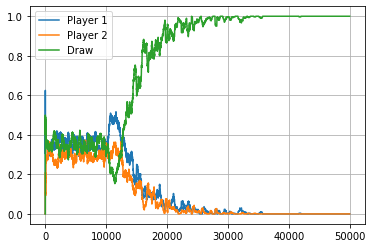

In [85]:
player1_freq = np.zeros((n_rounds,))
player2_freq = np.zeros((n_rounds,))
draw_freq = np.zeros((n_rounds,))
max_window_size = 300
for i in range(n_rounds):
    if i < max_window_size:
        frame = outcomes[:i]
        window_size = i+1
    else:
        frame = outcomes[(i-window_size):i]
        window_size = max_window_size
    player1_freq[i] = (frame.count('player1')/window_size)
    player2_freq[i] = (frame.count('player2')/window_size)
    draw_freq[i] = (frame.count(None)/window_size)
    
    

rounds = np.arange(n_rounds)
plt.plot(rounds, player1_freq, label='Player 1')
plt.plot(rounds, player2_freq, label='Player 2')
plt.plot(rounds, draw_freq, label='Draw')
plt.legend()
plt.grid()